## **load data**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip /content/drive/MyDrive/train.zip

In [212]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models
from torchvision.io import read_image
import torchvision
import torchvision.transforms as T
from torchvision.transforms.transforms import ToPILImage
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import matplotlib.pyplot as plt

to_image = T.ToPILImage()

### **plt settings**

In [ ]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

## **see data**

In [213]:
df_numeric_target = pd.read_csv('/content/drive/MyDrive/train_numeric_answers.csv')

In [214]:
df_numeric_target

,sum
0,6500
1,5500
2,7700
3,5400
4,2600
...,...
9995,2000
9996,3900
9997,4500
9998,4100


## **get some info from data**

In [215]:
df_numeric_target.describe()

,sum
count,10000.000000
mean,4804.280000
std,1768.222368
min,100.000000
25%,3600.000000
50%,4800.000000
75%,6000.000000
max,9600.000000


In [216]:
df_numeric_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sum     10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [217]:
from torchvision import transforms

transforms = torch.nn.Sequential(
    transforms.CenterCrop(100),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

tfs = transforms

In [218]:
X_data = []
y_data = []

for i in range(0, 10000):
    pic = read_image('/content/train/train_' + str(i) + '.png')
    pic = tfs(pic[0:3].type(torch.float))
    X_data.append(pic[0:3])
    y_data.append(torch.tensor(df_numeric_target.values[i]))

data = [X_data, y_data]

### **Take a look**

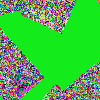

In [219]:
image = to_image(pic)
image

## **dataset class**

In [220]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y

        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def create_datasets(data, dataset_class, p_train=0.7, p_val=0.3, p_test=0.1):
    num_train = int(len(data[0])*p_train)
    num_val = int(len(data[0])*p_val)
    num_test = int(len(data[0])*p_test)

    X_train, y_train = data[0][:num_train], data[1][:num_train]
    X_val, y_val = data[0][num_train:num_train+num_val], data[1][num_train:num_train+num_val]
    X_test, y_test = data[0][-num_test:], data[1][-num_test:]

    data_train = dataset_class(X_train, y_train)
    data_valid = dataset_class(X_val, y_val)
    data_test = dataset_class(X_test, y_test)

    return data_train, data_valid, data_test
     

## **train, valid, test split**

In [221]:
data_train, data_valid, data_test = create_datasets([X_data, y_data], Dataset)

In [222]:
len(data_train), len(data_valid), len(data_test)

(7000, 3000, 1000)

In [223]:
batch_size = 256

train_dataloader = DataLoader(data_train, 
                              batch_size=batch_size,
                              drop_last=True)

valid_dataloader = DataLoader(data_valid, 
                              batch_size=batch_size,
                              drop_last=True)

test_dataloader = DataLoader(data_test, 
                              batch_size=batch_size,
                              drop_last=True)

In [224]:
loaders = {'train': train_dataloader, 'valid': valid_dataloader}

In [225]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## **neural network**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=1, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=6, stride=6)
        self.fc1 = nn.Linear(49, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 300)
        self.fc4 = nn.Linear(300, 50)
        self.fc5 = nn.Linear(50, 10)
        self.fc6 = nn.Linear(10, 1)

    
    def forward(self, x):
        x = x.type(torch.float32)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)

        return x

net = Net()
net

## **hyper parameters**

In [ ]:
max_epoch = 130

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## **train loop**

In [226]:
for epoch in range(max_epoch):
    for k, dataloader in loaders.items():
        RMSE_loss = 0
        for x_batch, y_batch in train_dataloader:
            if k == 'train':
                net.train()
                output = net.forward(x_batch)
                loss = torch.sqrt(criterion(output.to(torch.float32),
                                            y_batch.to(torch.float32)))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                net.eval()
                with torch.no_grad():
                    output = net.forward(x_batch)
            RMSE_loss += torch.sqrt(criterion(output.to(torch.float32),
                                         y_batch.to(torch.float32)))
        if k == 'train':
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. RMSE loss: {RMSE_loss}")

Epoch: 1
Loader: train. RMSE loss: 81224.96875
Loader: valid. RMSE loss: 50098.03515625
Epoch: 2
Loader: train. RMSE loss: 50104.4453125
Loader: valid. RMSE loss: 48562.2890625
Epoch: 3
Loader: train. RMSE loss: 47506.23828125
Loader: valid. RMSE loss: 47060.32421875
Epoch: 4
Loader: train. RMSE loss: 46162.73828125
Loader: valid. RMSE loss: 45201.0234375
Epoch: 5
Loader: train. RMSE loss: 44188.59375
Loader: valid. RMSE loss: 45522.9453125
Epoch: 6
Loader: train. RMSE loss: 43628.5
Loader: valid. RMSE loss: 44474.12109375
Epoch: 7
Loader: train. RMSE loss: 43098.53125
Loader: valid. RMSE loss: 45869.453125
Epoch: 8
Loader: train. RMSE loss: 43477.94921875
Loader: valid. RMSE loss: 45976.3515625
Epoch: 9
Loader: train. RMSE loss: 43552.71875
Loader: valid. RMSE loss: 42967.4765625
Epoch: 10
Loader: train. RMSE loss: 42604.05859375
Loader: valid. RMSE loss: 42525.80078125
Epoch: 11
Loader: train. RMSE loss: 42353.69921875
Loader: valid. RMSE loss: 42456.05859375
Epoch: 12
Loader: train.

### **test data score**

In [227]:
test_loss = 0
net.eval()
for x_batch, y_batch in test_dataloader:
    with torch.no_grad():
        output = net.forward(x_batch)
        test_loss += torch.sqrt(criterion(output.to(torch.float32),
                                          y_batch.to(torch.float32)))

print('loss on test data:', test_loss)

tensor(6231.2568)


## **let's see what we have learned!**

prediction: 8208
real sum: 2900


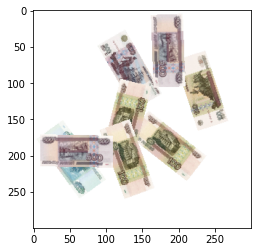


prediction: 5731
real sum: 4300


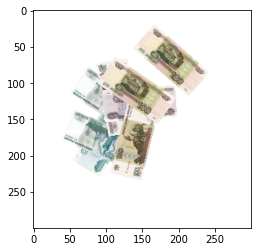


prediction: 2526
real sum: 1700


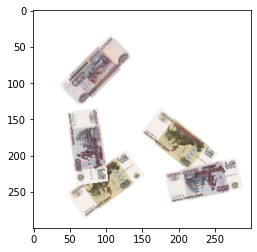


prediction: 6899
real sum: 9200


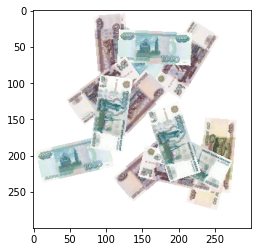


prediction: 1192
real sum: 4000


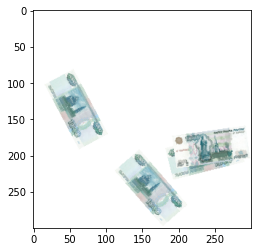


prediction: 7389
real sum: 6400


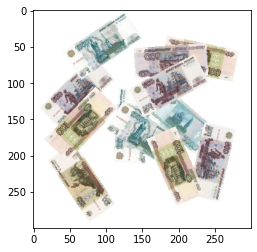


prediction: 5829
real sum: 3800


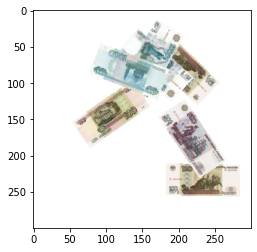


prediction: 4480
real sum: 6100


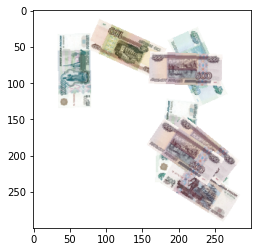


prediction: 6118
real sum: 6100


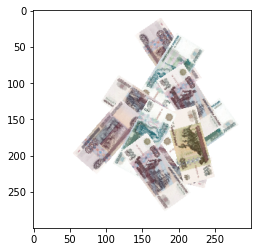


prediction: 3651
real sum: 4500


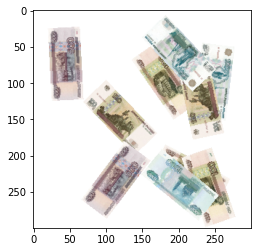

In [228]:
for i in range(9000, 9010):
    pic = read_image('/content/train/train_' + str(i) + '.png')

    tensor = tfs(pic[0:3].type(torch.float))
    predict = net.forward(tensor)
    print('prediction:', int(predict[0][0]))
    print('real sum:', int(y_data[i]))

    image = to_image(pic)
    plt.imshow(image)
    plt.show()

    print()